1.2.1
在完成基础 EDA 之后，需要进一步从光伏系统的物理机理验证数据是否合理，并判断影响发电量的主要因素。光伏电站的输出功率由“光照 → DC 发电 → 逆变器 → AC 输出”这一链路决定，因此数据分析必须回到机理本身。

为什么分析 DC_POWER vs IRRADIATION？

这是光伏系统最核心的物理关系：太阳辐照度决定组件的直流发电量（DC）。
通过散点图可以判断：

是否呈线性趋势（组件是否健康）

是否发生 clipping（削顶）

是否出现脏污/阴影等“扇形”分布

是否存在异常天或设备故障

因此这是检验一个电站状态最重要的图。

In [147]:
from src.shared_imports import *

1.2.2 全量散点图

图 1：DC_POWER vs IRRADIATION（所有数据）
用途：快速判断线性程度、 clipping、衰减、扇形等。

In [148]:
pwd

'e:\\solar-power-forecast-project'

In [149]:
df = pd.read_csv("data/processed/gen_sen_merged.csv")

In [150]:
df.head()

,DATE_TIME,SOURCE_KEY_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,HOUR_x,DATE_x,INVERTER_EFF,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,0,2020-05-15,NaN,25.184316,22.857507,0.0
1,2020-05-15 00:00:00,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,0,2020-05-15,NaN,25.184316,22.857507,0.0
2,2020-05-15 00:00:00,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,0,2020-05-15,NaN,25.184316,22.857507,0.0
3,2020-05-15 00:00:00,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,0,2020-05-15,NaN,25.184316,22.857507,0.0
4,2020-05-15 00:00:00,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,0,2020-05-15,NaN,25.184316,22.857507,0.0


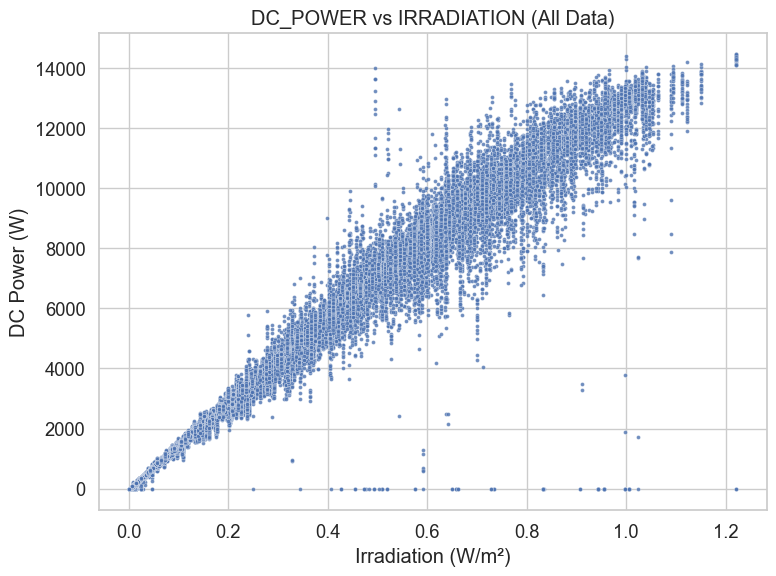

In [151]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="IRRADIATION",
    y="DC_POWER",
    s=8,
    alpha=0.8
)

plt.title("DC_POWER vs IRRADIATION (All Data)")
plt.xlabel("Irradiation (W/m²)")
plt.ylabel("DC Power (W)")
plt.tight_layout()
plt.show()

1）散点图整体呈线性，说明组件工作正常，但在高辐照度区域仍能看到部分点明显下沉。
2）同时存在“irradiation > 0.3 but DC=0”的异常点，可能是个别逆变器掉串或数据采集异常。
3）高辐照度段轻微弯曲，可能与温度升高导致的热衰减有关，后续将结合温度分析进一步确认。

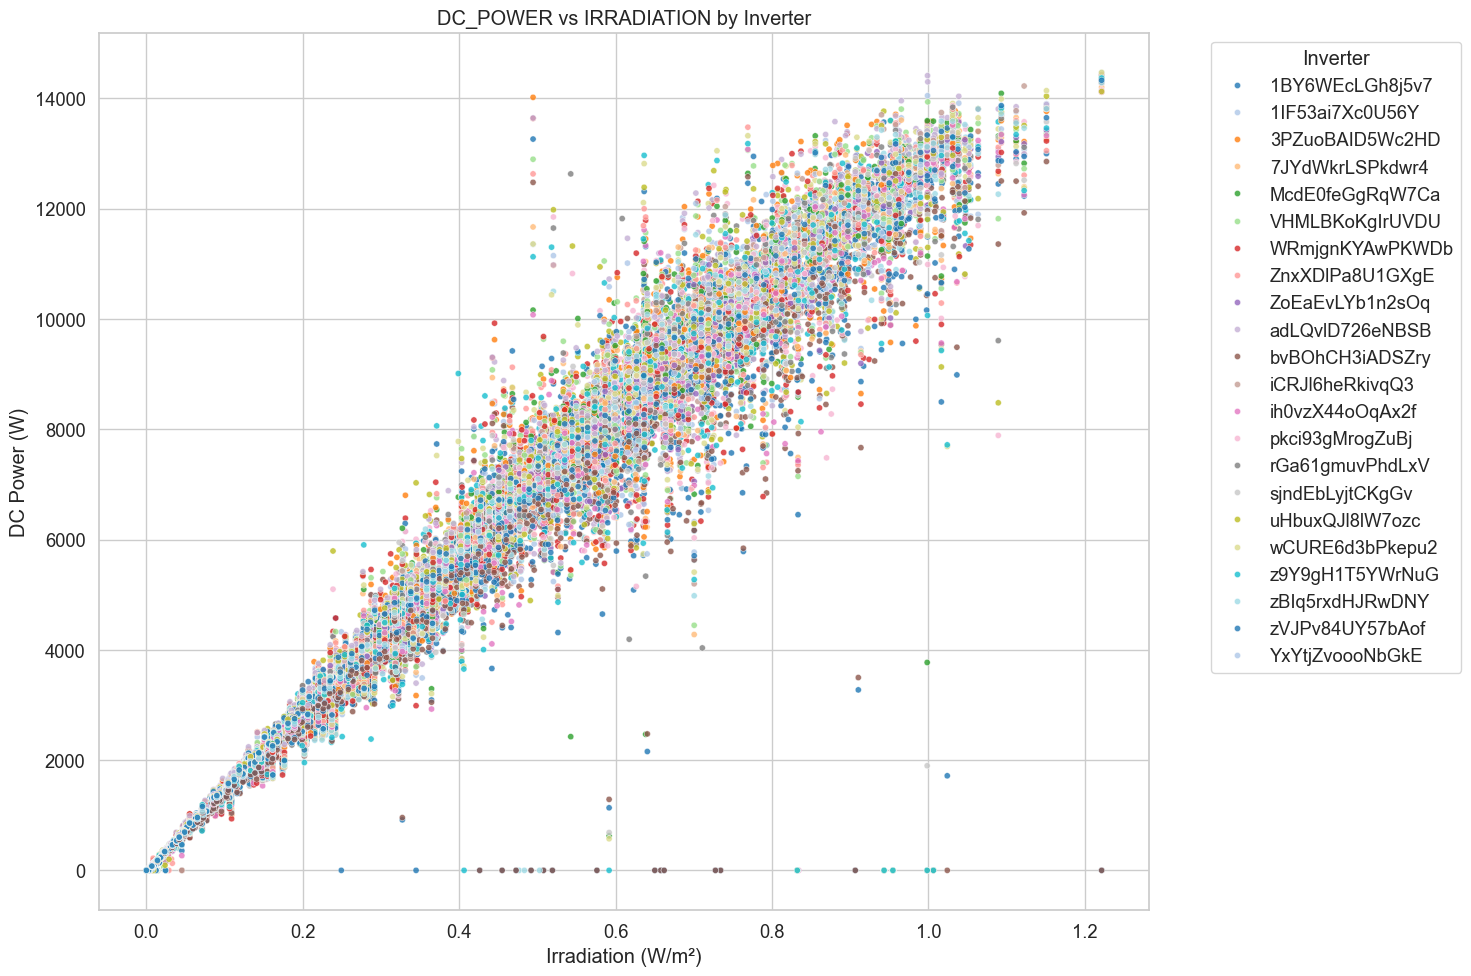

In [152]:
plt.figure(figsize=(15, 10))
sns.scatterplot(
    data=df,
    x="IRRADIATION",
    y="DC_POWER",
    hue="SOURCE_KEY_x",
    s=20,
    alpha=0.8,
    palette="tab20"
)

plt.title("DC_POWER vs IRRADIATION by Inverter")
plt.xlabel("Irradiation (W/m²)")
plt.ylabel("DC Power (W)")
plt.legend(title="Inverter", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [153]:
df_zero = df[(df["IRRADIATION"] > 0.3) & (df["DC_POWER"] == 0)]

# 按逆变器统计
zero_counts = df_zero.groupby("SOURCE_KEY_x")["DC_POWER"].count().sort_values(ascending=False)

print(zero_counts)

SOURCE_KEY_x
bvBOhCH3iADSZry    20
1BY6WEcLGh8j5v7    19
z9Y9gH1T5YWrNuG     7
wCURE6d3bPkepu2     5
McdE0feGgRqW7Ca     3
zBIq5rxdHJRwDNY     3
sjndEbLyjtCKgGv     3
ih0vzX44oOqAx2f     1
zVJPv84UY57bAof     1
Name: DC_POWER, dtype: int64


bvBOhCH3iADSZry 与 1BY6WEcLGh8j5v7 出现大量 “DC=0 但 irradiance > 0.3” 的异常点，说明这两台逆变器有明显掉串或输入中断现象，是最主要的异常设备。
根据之前的DC/AC时间趋势图，我们可以得知5/19–5/21和6/12–6/13这四天有明显的效率下降点，所以我们来集中分析这三问题机器在这个时间段内的表现。

In [154]:
target_inverters = [
    "bvBOhCH3iADSZry",
    "1BY6WEcLGh8j5v7",
    "z9Y9gH1T5YWrNuG"
]

In [155]:
date_list = [
    "2020-05-19", "2020-05-20", "2020-05-21",
    "2020-06-07", "2020-06-12", "2020-06-13", "2020-06-14"
]


In [156]:
df_filtered = df[
    (df["SOURCE_KEY_x"].isin(target_inverters)) &
    (df["DATE_x"].isin(date_list)) &
    (df["HOUR_x"].between(0, 25))
].copy()


In [157]:
print("Rows:", len(df_filtered))
print("Dates:", df_filtered["DATE_x"].unique())
print("Inverters:", df_filtered["SOURCE_KEY_x"].unique())

Rows: 1854
Dates: ['2020-05-19' '2020-05-20' '2020-05-21' '2020-06-07' '2020-06-12'
 '2020-06-13' '2020-06-14']
Inverters: ['1BY6WEcLGh8j5v7' 'bvBOhCH3iADSZry' 'z9Y9gH1T5YWrNuG']


1.2.3 按逆变器分色散点图/按时间（天）分色散点图

inverter_id
用途：判断是否存在掉串 / 某一台逆变器异常。
hue = DATE (day)
用途：判断是否存在脏污、PID、周末异常、特殊天气。

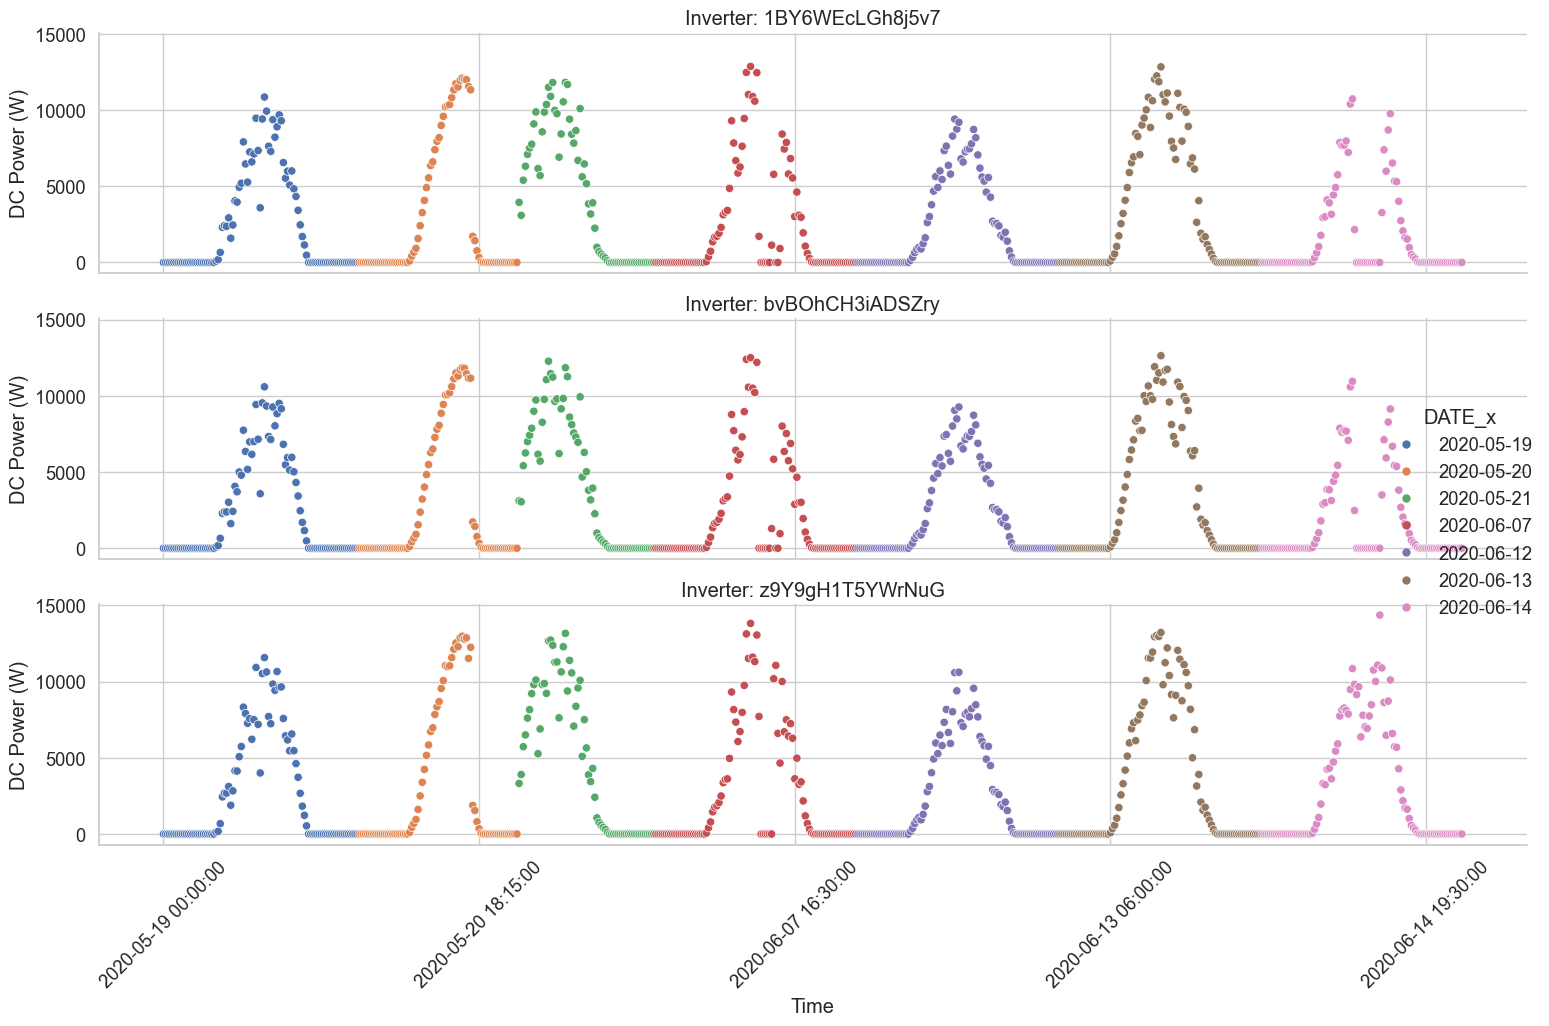

In [158]:
g = sns.relplot(
    data=df_filtered,
    x="DATE_TIME",
    y="DC_POWER",
    hue="DATE_x",         # 每天一条线（不同颜色）
    col="SOURCE_KEY_x",   # 每台 inverter 一个图
    kind="scatter",
    col_wrap=1,
    height=3.5,
    aspect=4
)
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))  
g.set_titles(col_template="Inverter: {col_name}")
g.set_axis_labels("Time", "DC Power (W)")

plt.tight_layout()
plt.show()

三台设备的异常具有同步性,问题不是逆变器故障，而很可能是：监控端采集缺失/气象数据或逆变器通信中断/电站侧通信异常
另外这三台机器都在6月7号的高温时间点有突然骤降到0的点，且6月14日'1BY6WEcLGh8j5v7'和'bvBOhCH3iADSZry'两台机器有大量在日照稳定的时候突然骤降至0的点
尽管5-20可能是监控端采集缺失问题但是仍然需要对这三台机器进行排查。

In [159]:
df_copy = df.copy()
df_copy.columns
df_copy.drop(['HOUR_x','DATE_x'], axis=1, inplace=True)

C:\Users\pearl\AppData\Local\Temp\ipykernel_26948\870710809.py:7: UserWarning: When passing multiple axes, layout keyword is ignored.
  df_copy.groupby(['time','day'])['DAILY_YIELD'].mean().unstack().plot(sharex=True,subplots=True,layout=(17,2),figsize=(20,20),style='-.',ax=ax)
C:\Users\pearl\AppData\Local\Temp\ipykernel_26948\870710809.py:7: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  df_copy.groupby(['time','day'])['DAILY_YIELD'].mean().unstack().plot(sharex=True,subplots=True,layout=(17,2),figsize=(20,20),style='-.',ax=ax)


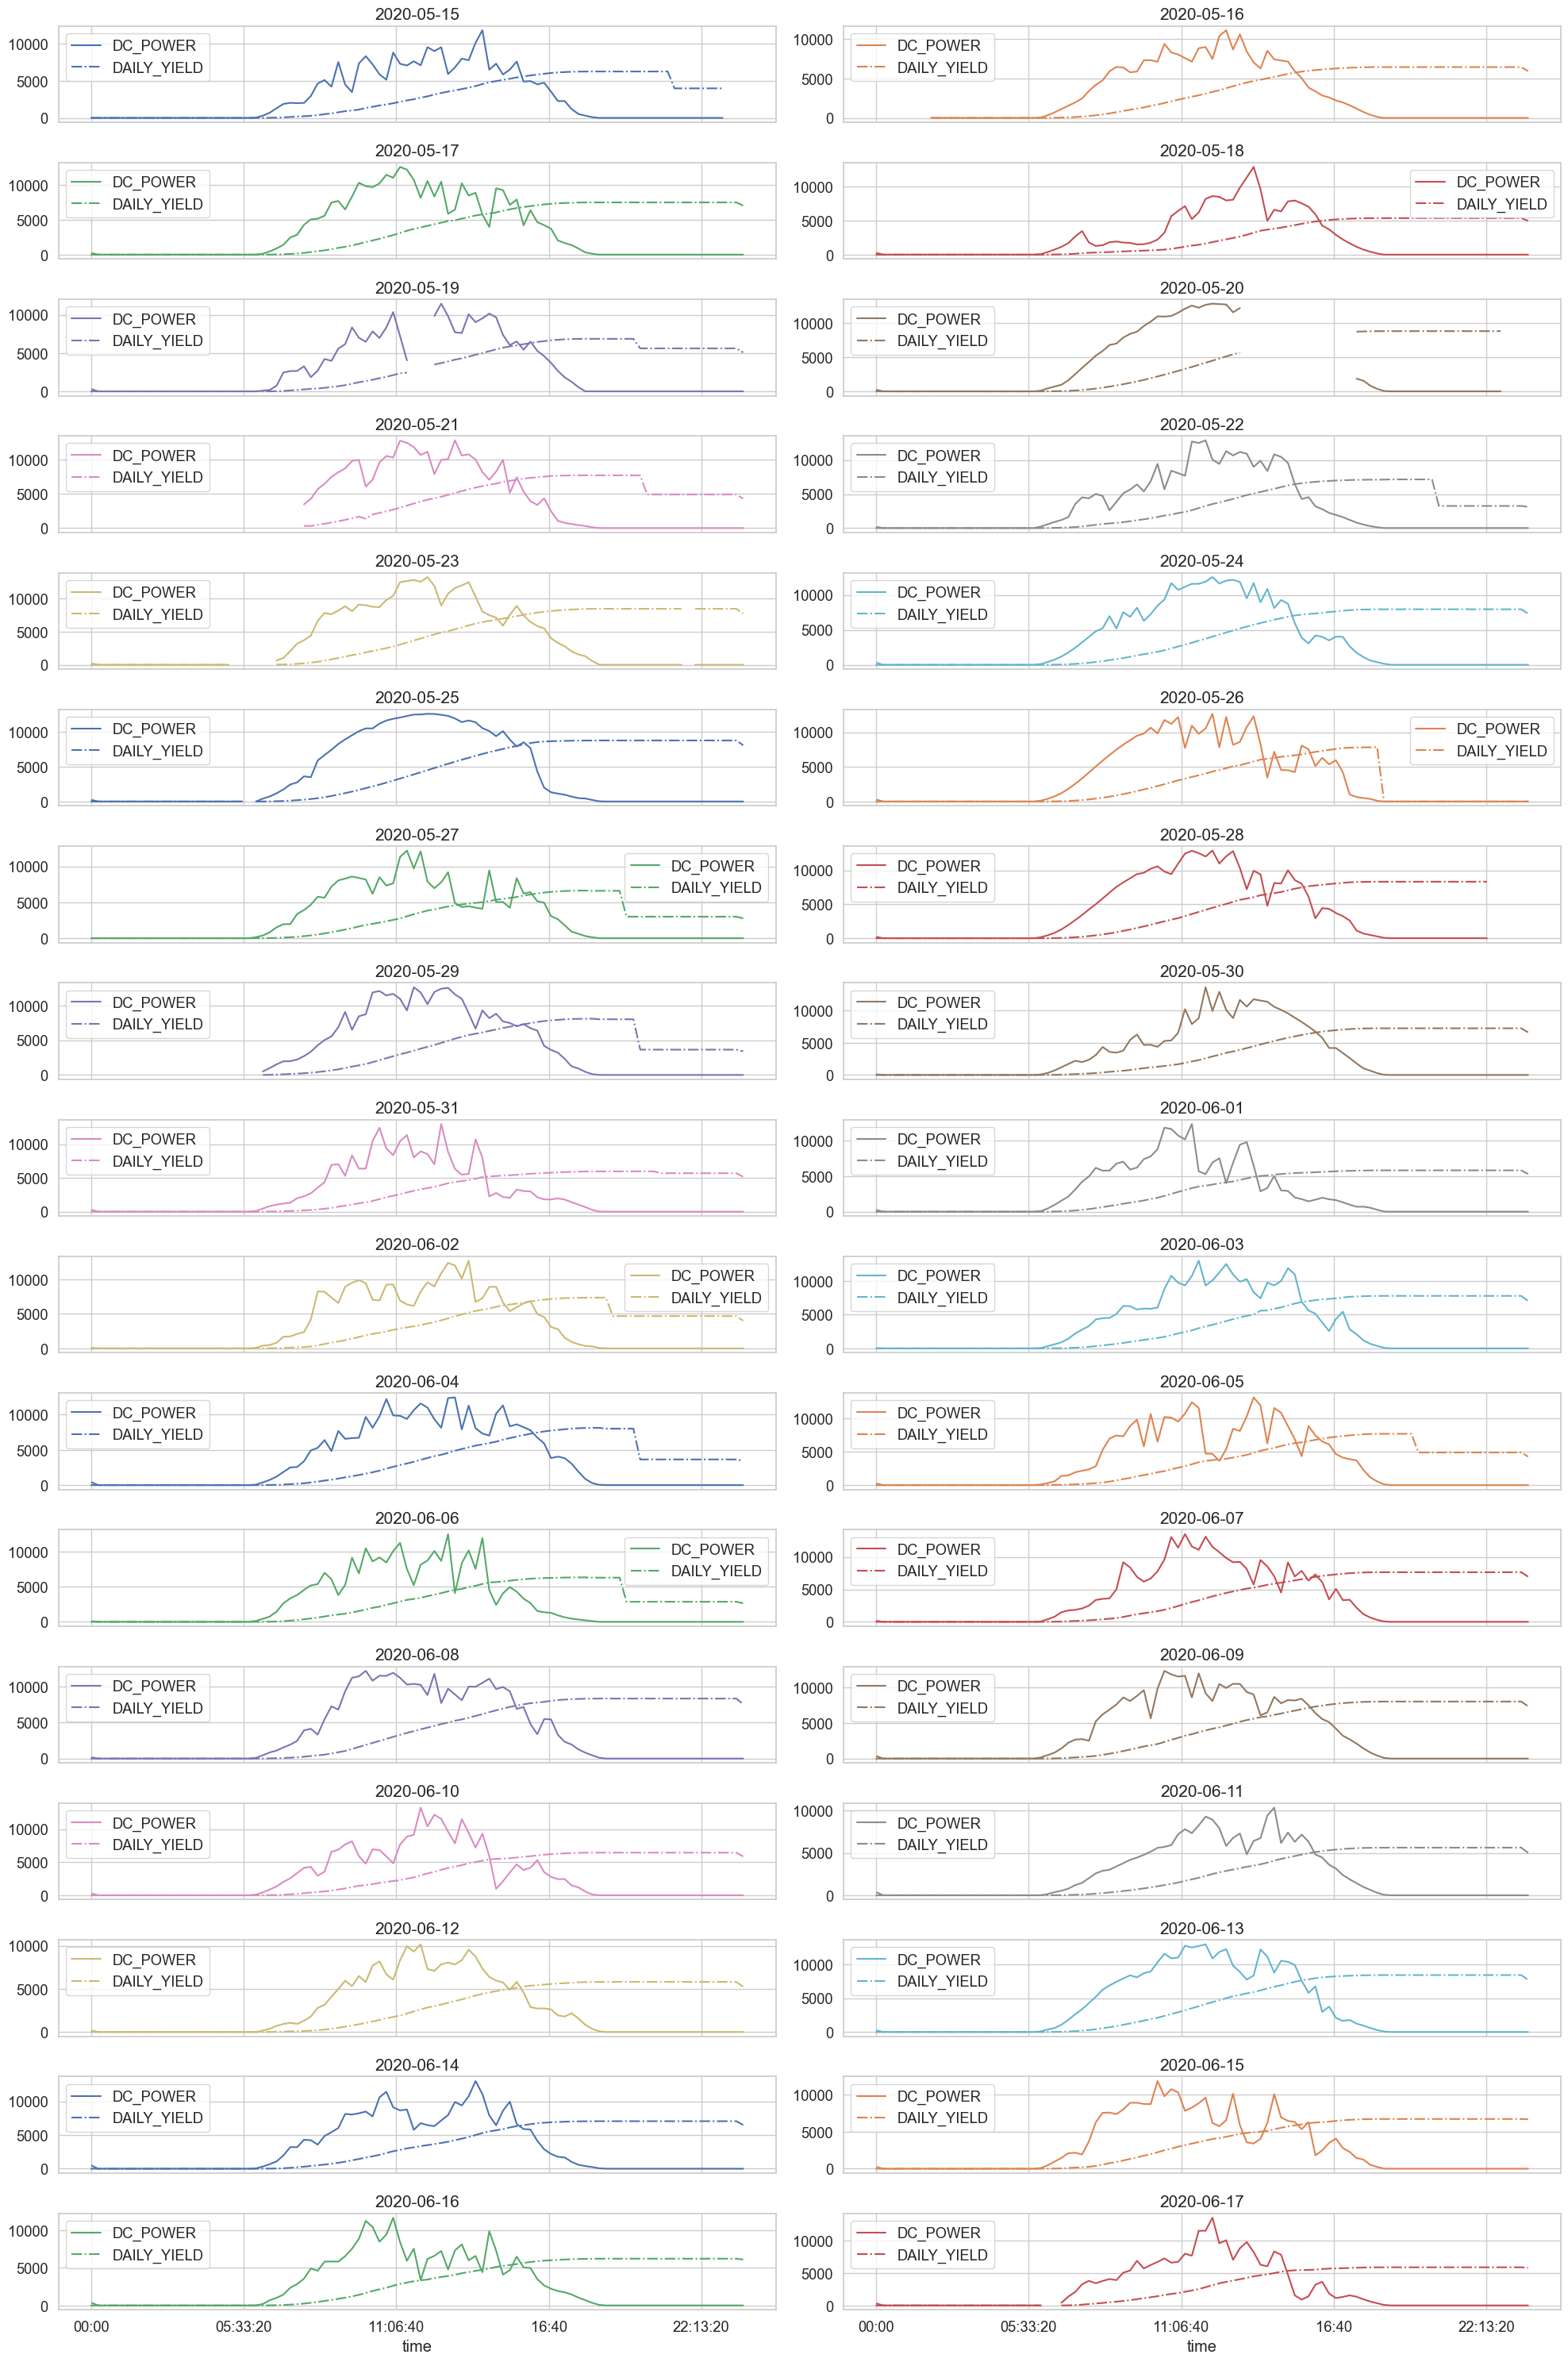

In [160]:
df_copy['DATE_TIME'] = pd.to_datetime(df_copy['DATE_TIME'])
df_copy['time'] = df_copy['DATE_TIME'].dt.time
df_copy['day'] = df_copy['DATE_TIME'].dt.date

cols = df_copy.groupby(['time','day'])['DC_POWER'].mean().unstack()
ax = df_copy.groupby(['time','day'])['DC_POWER'].mean().unstack().plot(sharex=True, subplots=True, layout=(17,2), figsize=(20,30))
df_copy.groupby(['time','day'])['DAILY_YIELD'].mean().unstack().plot(sharex=True,subplots=True,layout=(17,2),figsize=(20,20),style='-.',ax=ax)

i=0
for a in range(len(ax)):
    for b in range(len(ax[a])):
        ax[a,b].set_title(cols.columns[i],size=15)
        ax[a,b].legend(['DC_POWER','DAILY_YIELD'])
        i=i+1

plt.tight_layout()
plt.show()

5月19-21日整体的DC_POWER和DAYLY_YIELD数据缺失，验证了之前的猜想。